## Make bathymetry binary file based on netCDF bathy file bahia01_expand_bat.nc

In this notebook we prepare a bathymetry file for MITgcm based on the bathymetry developed by Esteban Cruz of a semi circular bay with no shelf (only slope). The bay is 120 km long and has a maximum depth of 160 m. The maximum depth in the domain is 1000 m.

We will make a bathymetry for a domain of size nx = 272, ny = 320, and a horizontal spacing of approximately 2 km (a coarse bathymetry, the real dx is 1.983 km and dy is 2.327 km).

The model will have 40 z levels of varying dz (starting from 2 m at the surface and increasing in thickness by 10.45% with each level).

The next bathimetries will include an elongated domain alongshore of increasing dx (telescopic) to avoid recirculation since AS boundaries will be periodic, and longer cross-shelf distance.

In [29]:
from netCDF4 import Dataset
import cmocean as cmo
import matplotlib.pyplot as plt
import numpy as np 
import scipy.interpolate as sci_interp

In [30]:
272/16

17.0

In [31]:

nc_file = 'bahia01_expand_bat.nc'

with Dataset(nc_file, 'r') as nbl:
    print(nbl.variables)

{'X': <class 'netCDF4._netCDF4.Variable'>
float32 X(y, x)
    units: meters
    description: Coordenadas X del dominio
unlimited dimensions: 
current shape = (3235, 2490)
filling on, default _FillValue of 9.969209968386869e+36 used, 'Y': <class 'netCDF4._netCDF4.Variable'>
float32 Y(y, x)
    units: meters
    description: Coordenadas Y del dominio
unlimited dimensions: 
current shape = (3235, 2490)
filling on, default _FillValue of 9.969209968386869e+36 used, 'Z': <class 'netCDF4._netCDF4.Variable'>
float32 Z(y, x)
    units: meters
    description: Datos de profundidad del dominio Z
unlimited dimensions: 
current shape = (3235, 2490)
filling on, default _FillValue of 9.969209968386869e+36 used, 'Z_sm': <class 'netCDF4._netCDF4.Variable'>
float32 Z_sm(y, x)
    units: meters
    description: Datos suavizados de profundidad del dominio Z
unlimited dimensions: 
current shape = (3235, 2490)
filling on, default _FillValue of 9.969209968386869e+36 used}


In [32]:
with Dataset(nc_file, 'r') as nbl:
    Xog = nbl.variables['X'][:].data
    Yog = nbl.variables['Y'][:].data
    Z = nbl.variables['Z_sm'][:].data

In [33]:
Xog.shape, Yog.shape, Z.shape

((3235, 2490), (3235, 2490), (3235, 2490))

In [34]:
DeltaX = np.diff(Xog)[0]
DeltaY = np.diff(Yog)[1]
print(DeltaX, DeltaY)


[21800. 21400. 21000. ... 21000. 21400. 21800.] [0. 0. 0. ... 0. 0. 0.]


In [35]:
# Show corners of the original bathymetry
print(f'left x-limit is {np.min(Xog)} m, and right x-limit is {np.max(Xog)} m')
print(f'bottom y-limit is {np.min(Yog)} m, and top y-limit is {np.max(Yog)} m')

left x-limit is -843000.0 m, and right x-limit is 843000.0 m
bottom y-limit is -682000.0 m, and top y-limit is 139000.0 m


In [36]:
682000 +139E3


821000.0

In [11]:
DeltaX = 200
nx_center = 238
x_max_center = DeltaX* nx_center/2
#DelX=int((2*x_max_center)/nx_center)
print(f'nx_center = {nx_center}, x_max_center = {x_max_center} m, DeltaX = {DeltaX} m')

DeltaY = 200
y_max = 139E3 # m
y_min = -62E3-8E3 # m
Distance = y_max - y_min
ny = int(Distance/DeltaY)

print(f'ny = {ny}, y_max = {y_max} m, y_min = {y_min} m, DeltaY = {DeltaY} m')

y_center = np.round(np.linspace(y_min, y_max ,ny), decimals=1)
dely= y_center[1:]-y_center[:-1]
print(f'ny = {ny}, y_center = {y_center}, dely = {dely}')

nx_center = 238, x_max_center = 23800.0 m, DeltaX = 200 m
ny = 1045, y_max = 139000.0 m, y_min = -70000.0 m, DeltaY = 200 m
ny = 1045, y_center = [-70000.  -69799.8 -69599.6 ... 138599.6 138799.8 139000. ], dely = [200.2 200.2 200.2 ... 200.2 200.2 200.2]


In [9]:
#Despues debemos quitar los puntos de costa extra que no necesitamos
# Sabemos que la costa esta en y = 0 m, la cabeza de labahia esta en y = 20000 m
# y el talud de la bahia esta en y = -62000 m y de ahí dejamos -62000 -8000
y_center = y_center[y_center>-70000]
#y_center = y_center[y_center<20000]
ny = len(y_center)
print(f'ny = {ny}, y_center = {y_center}')

ny = 1045, y_center = [-69970.6 -69770.4 -69570.3 ... 138599.7 138799.8 139000. ]


In [37]:
# Build x and y arrays for new bathymetry
# Set desired number of grid points along x and y
nx_center = 238 #De esta manera tenemos delX=2000 m
ny = 1045 #originalmente era 320
x_min_center = -238E2 # m Originalmente era -238E3
x_max_center =  238E2 # m Originalmente era 238E3
x_min_expand = - 843E3 # m
x_max_expand =  843E3 # m
y_min = -62E3-8E3 # m originalmente era -62E3 -440E2
y_min_expand = -682000 # m
y_max = 139E3 # m

DelX=int((2*x_max_center)/nx_center)

# Crear dominios en las regiones exteriores (-4L a -2L y 2L a 4L) con crecimiento cuadrático
# Aseguramos que el primer incremento sea 20 m usando un factor adecuado 'k'.
k = DelX # Ajustamos k para que el primer incremento sea 20 m
# Crear el vector para la expansión del lado derecho de forma más eficiente
i_values = np.arange(1, int(np.sqrt((x_max_expand - x_max_center) / k)) + 1)
i_values_y = np.arange(1, int(np.sqrt((np.abs(y_min_expand) - np.abs(y_min)) / k)) + 1)
x_right = x_max_center + k * i_values**2
y_expand = y_min - (k * i_values_y**2)
# Crear el vector para la expansión del lado izquierdo al reflejar y ordenar
x_left = -np.flip(x_right)
y_expand = np.flip(y_expand)
# Quitar los valores que se superponen con el centro
#x_left = x_left[:-1]
#x_right = x_right[1:]
#y_expand = y_expand[:-1]
# Crear el centro del dominio
x_center = np.round(np.linspace(x_min_center, x_max_center, nx_center), decimals=1)

# Unir todas las regiones para formar el dominio completo en X
x_vect = np.concatenate((x_left, x_center, x_right))

y_center = np.round(np.linspace(y_min, y_max ,ny), decimals=1)
y_vect = np.concatenate((y_expand, y_center))
#y_vect = np.round(np.linspace(y_min, y_max ,ny), decimals=1)

# Create interp function from original x, y and depth
f_interp = sci_interp.interp2d(Xog[0,:], Yog[:,0], Z)

# Interpolate into desired x and y vectors
bathy = f_interp(x_vect,y_vect)

/var/folders/md/v_9w0p656250q6gw5wc707040000gn/T/ipykernel_1640/2056120325.py:41: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f_interp = sci_interp.interp2d(Xog[0,:], Yog[:,0], Z)
/var/folders/md/v_9w0p656250q6gw5wc707040000gn/T/ipykernel_1640/2056120325.py:44: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids 

In [27]:
delx = x_center[1:]-x_center[:-1]
dely = y_center[1:]-y_center[:-1]
print(f'x_center.shape = {x_center.shape}, y_center.shape = {y_center.shape}')
print(f'delx.shape = {delx.shape}, dely.shape = {dely.shape}')
print(delx, dely)

x_center.shape = (238,), y_center.shape = (1045,)
delx.shape = (237,), dely.shape = (1044,)
[200.8 200.9 200.8 200.9 200.8 200.9 200.8 200.9 200.8 200.8 200.9 200.8
 200.9 200.8 200.9 200.8 200.8 200.9 200.8 200.9 200.8 200.9 200.8 200.9
 200.8 200.8 200.9 200.8 200.9 200.8 200.9 200.8 200.8 200.9 200.8 200.9
 200.8 200.9 200.8 200.9 200.8 200.8 200.9 200.8 200.9 200.8 200.9 200.8
 200.9 200.8 200.8 200.9 200.8 200.9 200.8 200.9 200.8 200.8 200.9 200.8
 200.9 200.8 200.9 200.8 200.9 200.8 200.8 200.9 200.8 200.9 200.8 200.9
 200.8 200.8 200.9 200.8 200.9 200.8 200.9 200.8 200.9 200.8 200.8 200.9
 200.8 200.9 200.8 200.9 200.8 200.8 200.9 200.8 200.9 200.8 200.9 200.8
 200.9 200.8 200.8 200.9 200.8 200.9 200.8 200.9 200.8 200.9 200.8 200.8
 200.9 200.8 200.9 200.8 200.9 200.8 200.8 200.9 200.8 200.9 200.8 200.9
 200.8 200.9 200.8 200.8 200.9 200.8 200.9 200.8 200.9 200.8 200.8 200.9
 200.8 200.9 200.8 200.9 200.8 200.9 200.8 200.8 200.9 200.8 200.9 200.8
 200.9 200.8 200.9 200.8 200.8 2

In [19]:
print(bathy.shape)
print(y_vect.shape)

(1100, 366)
(1100,)


In [38]:
# Construimos una máscara booleana
mask_Ydomain = (y_vect < 20000)  # array de True/False, longitud = len(y_vect)

# Aplicamos la máscara tanto a bathy como a y_vect
bathy_sub = bathy[mask_Ydomain, :]   # Filtramos filas
y_vect_sub = y_vect[mask_Ydomain]    # Filtramos las coordenadas y
print(f'bathy.shape = {bathy.shape}')
print(f'bathy_sub.shape = {bathy_sub.shape}')


bathy.shape = (1100, 366)
bathy_sub.shape = (505, 366)


In [ ]:
y_vect_sub[2]

19886.0

In [ ]:
#Necesitoamos que nx=272 y ny=320, entonces seccionamos bathy y y_vect
# Con las nuevas dimensiones de la bahía
#  Necesitamos (ny=496, nx=352) y actualmente tenemos (ny= 505, nx= 366)
# Entonces necesitamos cortar 9 filas y 14 columnas 
#Modificamos las dimensiones de la bahía
bathy=bathy_sub
y_vect = y_vect_sub

#Recortamos las columnas de manera simétrica (el dominio en x)
bathy=bathy[:,7:-7]
x_vect = x_vect[7:-7]
print(x_vect.shape)

#Recortamos las filas (el dominio en y)
bathy=bathy[9:,:]
y_vect = y_vect_sub
y_vect = y_vect[9:]

print(bathy.shape)
print(y_vect.shape)

(496, 352)
(496,)


In [40]:
#x_vect = x_vect[7:-7]
print(x_vect.shape)
print(y_vect.shape)

(352,)
(496,)


'dominio_bath.png'

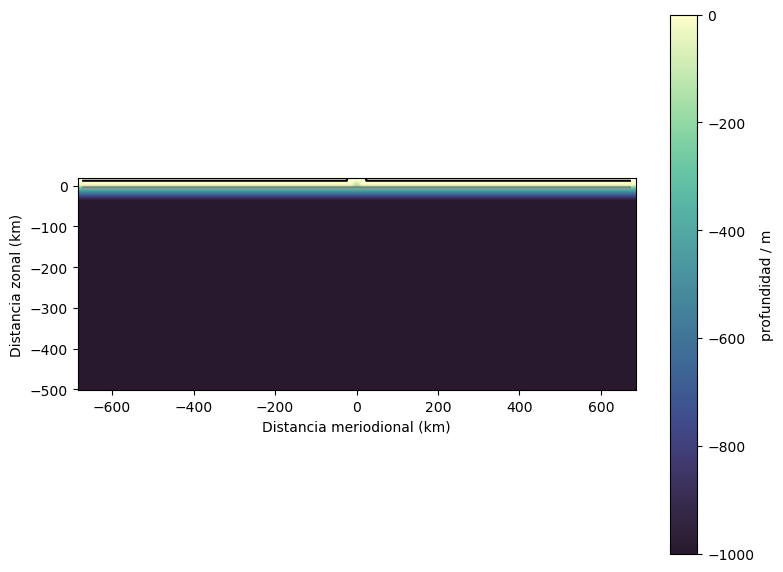

In [41]:
# Plot interp bathymetry

fig, ax = plt.subplots(1,1,figsize=(9,7))
pc = ax.pcolormesh(x_vect/1000,y_vect/1000,bathy, cmap=cmo.cm.deep_r)
cb = plt.colorbar(pc)

ax.contour(x_vect/1000,y_vect/1000,-bathy, colors='0.5', levels=[250])
ax.contour(x_vect/1000,y_vect/1000,-bathy, colors='k', levels=[0])

cb.set_label('profundidad / m')
ax.set_xlabel('Distancia meriodional (km)')
ax.set_ylabel('Distancia zonal (km)')

ax.set_aspect(1)

# Save the plot as a PNG file
file_path = "dominio_bath.png"
plt.savefig(file_path, dpi=300)
file_path

Text(0, 0.5, 'Depth (m)')

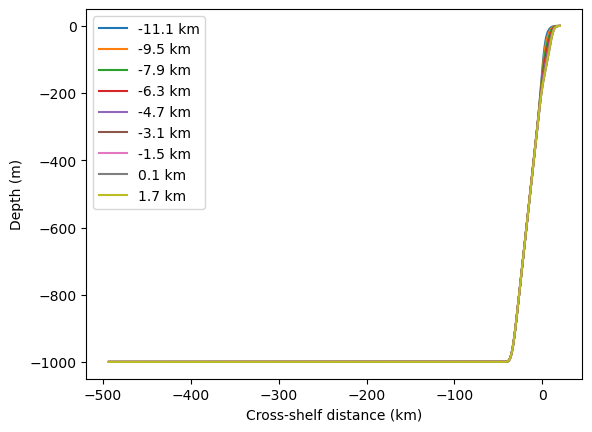

In [42]:
# Check some cross-shelf profiles starting from the center of the bay (0 km)
for ii in range(120,186,8):
    plt.plot(y_vect[:]/1E3,bathy[:,ii], label=f'{x_vect[ii]/1E3:1.1f} km')
plt.legend()
plt.xlabel('Cross-shelf distance (km)')
plt.ylabel('Depth (m)')

In [43]:
# Build grid spacing vectors dx and dy 
delx = x_vect[1:]-x_vect[:-1]
dely = y_vect[1:]-y_vect[:-1]
dx = np.append(delx, [delx[-1]], axis=0) # This is not the best way to do this
dy = np.append(dely, [dely[-1]], axis=0)

#Check values:
print(dx)
print(dy)

[22600.  22200.  21800.  21400.  21000.  20600.  20200.  19800.  19400.
 19000.  18600.  18200.  17800.  17400.  17000.  16600.  16200.  15800.
 15400.  15000.  14600.  14200.  13800.  13400.  13000.  12600.  12200.
 11800.  11400.  11000.  10600.  10200.   9800.   9400.   9000.   8600.
  8200.   7800.   7400.   7000.   6600.   6200.   5800.   5400.   5000.
  4600.   4200.   3800.   3400.   3000.   2600.   2200.   1800.   1400.
  1000.    600.    200.    200.8   200.9   200.8   200.9   200.8   200.9
   200.8   200.9   200.8   200.8   200.9   200.8   200.9   200.8   200.9
   200.8   200.8   200.9   200.8   200.9   200.8   200.9   200.8   200.9
   200.8   200.8   200.9   200.8   200.9   200.8   200.9   200.8   200.8
   200.9   200.8   200.9   200.8   200.9   200.8   200.9   200.8   200.8
   200.9   200.8   200.9   200.8   200.9   200.8   200.9   200.8   200.8
   200.9   200.8   200.9   200.8   200.9   200.8   200.8   200.9   200.8
   200.9   200.8   200.9   200.8   200.9   200.8   200.8 

In [15]:
# Set filenames for binary files and data type
#bathy_fname = 'bahia_01_noShelf_bat.bin'
#dx_fname = 'bahia_01_noShelf_dx.bin'
#dy_fname = 'bahia_01_noShelf_dy.bin'
#dt = np.dtype('>f8')  # float 64 big endian

In [16]:
len(dx)

272

In [44]:
bathy_fname = 'bahia_01_expand_bat.bin'
dx_fname = 'bahia_01_expand_dx.bin'
dy_fname = 'bahia_01_expand_dy.bin'
dt = np.dtype('>f8')  # float 64 big endian

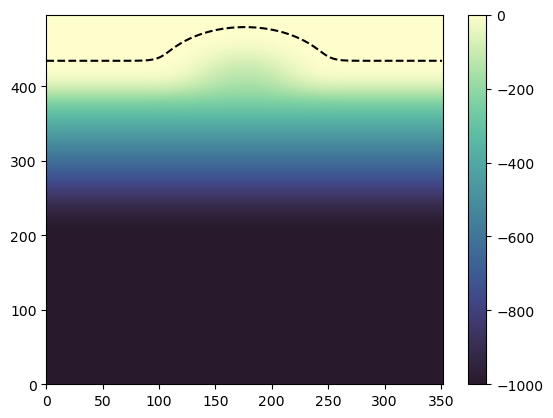

In [45]:
# Save binary files for dx, dy, bathy
fileobj = open(dx_fname,mode='wb')
dx.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(dy_fname, mode='wb')
dy.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(bathy_fname, mode='wb')
dd=bathy
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

# Quick check
plt.pcolor(dd, cmap=cmo.cm.deep_r)
plt.colorbar()
plt.contour(dd, levels=[-1,0], colors='k')
plt.show()

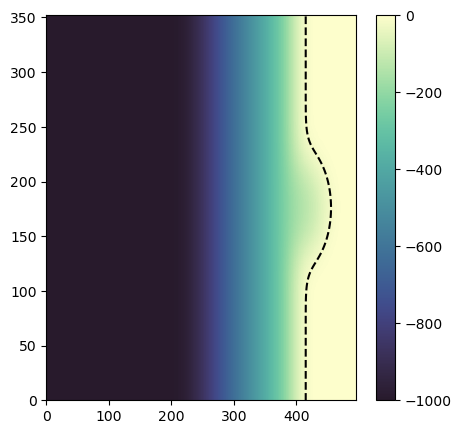

In [46]:
# Check it is read correctly
cc=np.fromfile(bathy_fname, dtype=dt)
np.shape(cc)

nx= len(x_vect)
ny= len(y_vect)
bF=np.reshape(cc,[nx,ny],'F') # F to read in Fortran order

fig,ax = plt.subplots(1,1, figsize=(5,5))

pc = ax.pcolormesh(bF, cmap=cmo.cm.deep_r)
plt.colorbar(pc,ax=ax)
ax.contour(bF, levels=[-20,0], colors='k')

Yes, that is how it should look to go into MITgcm.

In [20]:
%whos

Variable          Type              Data/Info
---------------------------------------------
Dataset           type              <class 'netCDF4._netCDF4.Dataset'>
DelX              int               2000
NamespaceMagics   MetaHasTraits     <class 'IPython.core.magi<...>mespace.NamespaceMagics'>
Xog               ndarray           3235x2490: 8055150 elems, type `float32`, 32220600 bytes (30.72795867919922 Mb)
Yog               ndarray           3235x2490: 8055150 elems, type `float32`, 32220600 bytes (30.72795867919922 Mb)
Z                 ndarray           3235x2490: 8055150 elems, type `float32`, 32220600 bytes (30.72795867919922 Mb)
ax                Axes              Axes(0.125,0.11;0.62x0.77)
bF                ndarray           272x320: 87040 elems, type `>f8`, 696320 bytes (680.0 kb)
bathy             ndarray           320x272: 87040 elems, type `float64`, 696320 bytes (680.0 kb)
bathy_fname       str               bahia_01_expand_bat.bin
cb                Colorbar          <matp

In [21]:
sNx =   17
sNy =   20
OLx =   3
OLy =   3
nSx =   16
nSy =   16
nPx =   1
nPy =   1
Nx  = sNx*nSx*nPx 
Ny  = sNy*nSy*nPy

In [22]:
320/16

20.0

In [23]:
Nx

272

In [24]:
Ny

320